# Realtor Scrapy

Scrapy the real state website and retrieve house listing of a target price and retrieve the info.

### Import Dependencies

In [88]:
import os
from bs4 import BeautifulSoup
import requests
from splinter import Browser
import pandas as pd
import time
import numpy as np
import pprint

# Import DB user and password
from api_keys import positionstack_key
from api_keys import opencagedata_API
from api_keys import DATABASE_URL

### Setup Splinter (For Mac)

In [89]:
# identify location of chromedriver and store it as a variable
driverPath = !which chromedriver

# Setup configuration variables to enable Splinter to interact with browser
executable_path = {'executable_path': driverPath[0]}
browser = Browser('chrome', **executable_path, headless=False)

### Scraping

In [90]:
# URL of page to be scraped
url_realtor = "https://www.realtor.com/realestateandhomes-search/Houston_TX/type-single-family-home/price-"
link_details = "https://www.realtor.com"
min_price = '200000'
max_price = '300000'
sort_by = '/sby-2' # Highest to lowest price
sort_by = '/sby-6' # Newest listings
page_number = 1

query_url = f"{url_realtor}{min_price}-{max_price}{sort_by}/pg-{page_number}"
print(query_url)

https://www.realtor.com/realestateandhomes-search/Houston_TX/type-single-family-home/price-200000-300000/sby-6/pg-1


### BeautifulSoup

In [91]:
# Scrap with BeautifulSoup. However it does 
# page = requests.get(query_url)
# soup = BeautifulSoup(page.content, 'html.parser')

### Splinter

In [92]:
# Use the browser to visit the url
browser.visit(query_url)

In [93]:
# Wait for x seconds for error purpouses
time.sleep(5)

In [94]:
# Return the rendered page by the browser
html_realtor = browser.html

In [95]:
# Use beatifulsoup to scrap the page rendered by the browser
soup = BeautifulSoup(html_realtor, 'html.parser')

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/

In [96]:
# Search for the div where the title is located
results = soup.find_all('div', class_="card-box")
# print(results[0].prettify())
print(f"Total results: {len(results)}")

Total results: 48


In [97]:
results[6].find('ul').find_all('span')

[<span class="jsx-2256820618 meta-value" data-label="meta-value">4</span>,
 <span class="jsx-2256820618 meta-label" data-label="meta-label">bed</span>,
 <span class="jsx-2256820618 meta-value" data-label="meta-value">2.5</span>,
 <span class="jsx-2256820618 meta-label" data-label="meta-label">bath</span>,
 <span class="jsx-2256820618 meta-value" data-label="meta-value">2,240</span>,
 <span class="jsx-2256820618 meta-label" data-label="meta-label">sqft</span>,
 <span class="jsx-2256820618 meta-value" data-label="meta-value">5,760</span>,
 <span class="jsx-2256820618 meta-label" data-label="meta-label">sqft lot</span>]

In [98]:
# Find beds, baths, sqft and lot
def find_features(house_feat_temp):
    list_features = []
    for jj in range(len(house_feat_temp)):
        list_features.append(house_feat_temp[jj].text)

    try:
        index_pos = list_features.index("bed")
    except ValueError:
        bed = 1.0
    else:
        bed = float(list_features[index_pos-1])

    try:
        index_pos = list_features.index("bath")
    except ValueError:
        bath = 1.0
    else:
        bath = float(list_features[index_pos-1].replace("+",""))

    try:
        index_pos = list_features.index("sqft")
    except ValueError:
        sqft = np.nan
    else:
        sqft = float(list_features[index_pos-1].replace(",",""))

    try:
        index_pos = list_features.index("sqft lot")
    except ValueError:
        try:
            index_pos = list_features.index("acre lot")
        except ValueError:
            lot = np.nan
        else:
            lot = round(float(list_features[index_pos-1])*43560)    
    else:
        lot = float(list_features[index_pos-1].replace(',',''))

#     print(f"Beds: {bed}, Bath: {bath}, Sqft: {sqft}, Lot: {lot}")
    
    return {"Beds": bed, "Bath": bath, "Sqft": sqft, "Lot": lot}

find_features(results[6].find('ul').find_all('span'))

{'Beds': 4.0, 'Bath': 2.5, 'Sqft': 2240.0, 'Lot': 5760.0}

In [99]:
# Print results and save to a dictionary
n = 0
realstate_list = []
for result in results:
#     Clear the variables to not store repeated info
    house_price = ''
    address = ''
    link_page = ''
    photo_url = ''
                
    n = n + 1
    print('-----------------------------------')
    print('')
    print(f'Result: {n} of {len(results)}')
    if not result.find('div', class_="ads"):
#         print(f'Result: {n} of {len(results)}')
        price_div = result.find('div', class_="price")
        house_price = float(price_div.find('span').text.split('$')[-1].replace(",",""))
        link_page = result.find('a')['href']
        img_label = result.find('img')
        address = img_label['alt']
        
        
#         house_features = result.find('ul').text
#         list_house_features = house_features.replace("bed",";").replace("bath",";").replace("lot",";").replace("sqft",";").split(";")
#         bed = float(list_house_features[0])
#         bath = float(list_house_features[1])
#         sqft = int(list_house_features[2].replace(",",""))
#         lot = list_house_features[3]

#         # Convert acre to sqft
#         if (lot.find('acre') != -1): 
#             lot = (round(float(lot.replace('acre',''))*43560))
#         else:
#             lot = int(lot.replace(",",""))

        

        features = find_features(result.find('ul').find_all('span'))
        
        bed = features['Beds']
        bath = features['Bath']
        sqft = features['Sqft']
        lot = features['Lot']
            
        print(f"Price: ${house_price} | Beds: {bed}, Bath: {bath}, Sqft: {sqft}, Lot: {lot}")
        
        print(f"Address: {address}")
        
        try:
            price_reduced = result.find('span', class_="price-reduced-amount")
            price_now = price_reduced.text
            print(f"Price reduced: {price_now}")
        except:
            pass
        print(f"Link: {link_details}{link_page}")
#         photo_url = img_label['srcset'].split(',')[1].split(' ')[1]
        try:
            photo_url = img_label['srcset'].split(',')[1].split(' ')[1]
            print(f"Photo link: {photo_url}")
        except KeyError:
            print(f"Photo not available")
            
        separator = '+'
        address_google = separator.join(address.split(" "))
        url_google_maps = f"https://www.google.com/maps/place/{address_google}"
        print(f"Google Maps: {url_google_maps}")
    
        
        # Save results to a dictionary
        realstate_list.append(
            {
                "Price": house_price,
                "Address": address,
                "Beds": bed,
                "Baths": bath,
                "Sqft": sqft,
                "Lot": lot,
                "Link": str(link_details+link_page),
                "Photo link": photo_url,
                "Google Maps": url_google_maps
            }
        )

    
    else:
        print('Data not available or Ads')

    print('')
    
    

-----------------------------------

Result: 1 of 48
Price: $299900.0 | Beds: 3.0, Bath: 1.0, Sqft: 1352.0, Lot: 7200.0
Address: 4026 Cheena Dr, Houston, TX 77025
Link: https://www.realtor.com/realestateandhomes-detail/4026-Cheena-Dr_Houston_TX_77025_M78379-39548
Photo link: https://ap.rdcpix.com/057b703da62d556b766fef9b39ea43fal-m4066058859od-w480_h360_x2.jpg
Google Maps: https://www.google.com/maps/place/4026+Cheena+Dr,+Houston,+TX+77025

-----------------------------------

Result: 2 of 48
Price: $252000.0 | Beds: 3.0, Bath: 2.5, Sqft: 2408.0, Lot: 8800.0
Address: 11934 Gardenglen Dr, Houston, TX 77070
Link: https://www.realtor.com/realestateandhomes-detail/11934-Gardenglen-Dr_Houston_TX_77070_M83000-74411
Photo link: https://ap.rdcpix.com/52e863b67f6c51c9b46002839e4b8cccl-m3820968858od-w480_h360_x2.jpg
Google Maps: https://www.google.com/maps/place/11934+Gardenglen+Dr,+Houston,+TX+77070

-----------------------------------

Result: 3 of 48
Price: $285000.0 | Beds: 3.0, Bath: 2.0, S

-----------------------------------

Result: 28 of 48
Price: $237000.0 | Beds: 3.0, Bath: 2.5, Sqft: 2445.0, Lot: 4366.0
Address: 15015 Middle Oaks Blvd, Houston, TX 77082
Link: https://www.realtor.com/realestateandhomes-detail/15015-Middle-Oaks-Blvd_Houston_TX_77082_M83952-23899
Photo not available
Google Maps: https://www.google.com/maps/place/15015+Middle+Oaks+Blvd,+Houston,+TX+77082

-----------------------------------

Result: 29 of 48
Price: $242500.0 | Beds: 5.0, Bath: 2.5, Sqft: 2671.0, Lot: 10890
Address: 10606 Archmont Dr, Houston, TX 77070
Link: https://www.realtor.com/realestateandhomes-detail/10606-Archmont-Dr_Houston_TX_77070_M74083-40912
Photo not available
Google Maps: https://www.google.com/maps/place/10606+Archmont+Dr,+Houston,+TX+77070

-----------------------------------

Result: 30 of 48
Price: $239900.0 | Beds: 3.0, Bath: 2.5, Sqft: 1365.0, Lot: 3750.0
Address: 3706 Dreyfus St, Houston, TX 77021
Price reduced: $5k
Link: https://www.realtor.com/realestateandhomes-d

In [100]:
# When you’ve finished testing, close your browser using browser.quit:
browser.quit()

<hr style="border: 3px solid red;">

### Data Cleaning

In [101]:
# Save the data to a dataframe
listing_df = pd.DataFrame(realstate_list)
# listing_df.to_csv(os.path.join('Database','ScrapedData.csv'))
listing_df

,Price,Address,Beds,Baths,Sqft,Lot,Link,Photo link,Google Maps
0,299900.0,"4026 Cheena Dr, Houston, TX 77025",3.0,1.0,1352.0,7200.0,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/057b703da62d556b766fef9b...,https://www.google.com/maps/place/4026+Cheena+...
1,252000.0,"11934 Gardenglen Dr, Houston, TX 77070",3.0,2.5,2408.0,8800.0,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/52e863b67f6c51c9b4600283...,https://www.google.com/maps/place/11934+Garden...
2,285000.0,"14138 Hillvale Dr, Houston, TX 77077",3.0,2.0,2088.0,4569.0,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/66e09a805d83407aa570a627...,https://www.google.com/maps/place/14138+Hillva...
3,267500.0,"2107 Lazy Grove Dr, Houston, TX 77339",4.0,2.5,2908.0,10890.0,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/289f519f7d9d0b65247fd85a...,https://www.google.com/maps/place/2107+Lazy+Gr...
4,223000.0,"12539 Bridle Springs Ln, Houston, TX 77044",3.0,2.0,1700.0,6250.0,https://www.realtor.com/realestateandhomes-det...,https://maps.googleapis.com/maps/api/streetvie...,https://www.google.com/maps/place/12539+Bridle...
5,209900.0,"11115 Lovington Dr, Houston, TX 77088",4.0,2.5,2240.0,5760.0,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/998d913175ef2bd5e279cd03...,https://www.google.com/maps/place/11115+Loving...
6,271900.0,"6123 Summerville Ln, Houston, TX 77041",4.0,2.5,2710.0,8056.0,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/ea5d158d1c5cc436c5c12afd...,https://www.google.com/maps/place/6123+Summerv...
7,225000.0,"3450 Noah St, Houston, TX 77021",3.0,2.0,1500.0,5000.0,https://www.realtor.com/realestateandhomes-det...,https://maps.googleapis.com/maps/api/streetvie...,https://www.google.com/maps/place/3450+Noah+St...
8,229000.0,"10715 Crestfield Ct, Houston, TX 77070",3.0,2.5,2107.0,8404.0,https://www.realtor.com/realestateandhomes-det...,,https://www.google.com/maps/place/10715+Crestf...
9,200000.0,"17619 Glenmark Dr, Houston, TX 77084",4.0,2.0,1844.0,6300.0,https://www.realtor.com/realestateandhomes-det...,,https://www.google.com/maps/place/17619+Glenma...


In [102]:
# Dataframe to dictionary
listing_df.to_dict(orient="records")

[{'Price': 299900.0,
  'Address': '4026 Cheena Dr, Houston, TX 77025',
  'Beds': 3.0,
  'Baths': 1.0,
  'Sqft': 1352.0,
  'Lot': 7200.0,
  'Link': 'https://www.realtor.com/realestateandhomes-detail/4026-Cheena-Dr_Houston_TX_77025_M78379-39548',
  'Photo link': 'https://ap.rdcpix.com/057b703da62d556b766fef9b39ea43fal-m4066058859od-w480_h360_x2.jpg',
  'Google Maps': 'https://www.google.com/maps/place/4026+Cheena+Dr,+Houston,+TX+77025'},
 {'Price': 252000.0,
  'Address': '11934 Gardenglen Dr, Houston, TX 77070',
  'Beds': 3.0,
  'Baths': 2.5,
  'Sqft': 2408.0,
  'Lot': 8800.0,
  'Link': 'https://www.realtor.com/realestateandhomes-detail/11934-Gardenglen-Dr_Houston_TX_77070_M83000-74411',
  'Photo link': 'https://ap.rdcpix.com/52e863b67f6c51c9b46002839e4b8cccl-m3820968858od-w480_h360_x2.jpg',
  'Google Maps': 'https://www.google.com/maps/place/11934+Gardenglen+Dr,+Houston,+TX+77070'},
 {'Price': 285000.0,
  'Address': '14138 Hillvale Dr, Houston, TX 77077',
  'Beds': 3.0,
  'Baths': 2.0,


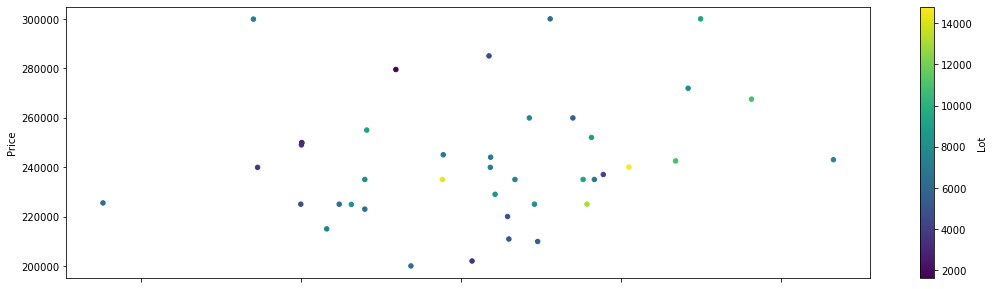

In [103]:
ax1 = listing_df.plot.scatter(x='Sqft',y='Price',c='Lot', colormap='viridis',figsize=(18,5))

<hr style="border: 3px solid red;">

## Save Scraped House Data to Database

In [104]:
 # Imports the method used to connect to DBs
from sqlalchemy import create_engine
from sqlalchemy import exc

# Imports the methods needed to abstract python classes into database tables
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

# function to establish a session with a connected database
from sqlalchemy.orm import Session

# database compliant datatypes
from sqlalchemy import Column, Integer, String, Float

# from config import db_user, dialect

In [105]:
# Create database connection
engine = create_engine(DATABASE_URL) 

In [106]:
# Create class to frame each real state instance
class RealState(Base):
    __tablename__ = 'realstatelisting'

    house_id = Column(Integer, primary_key=True)
    address = Column(String(300), unique=True, nullable=False)
    price = Column(Float, nullable=False)
    bed = Column(Float, nullable=True)
    bath = Column(Float, nullable=True)
    sqft = Column(Float, nullable=True)
    lot = Column(Float, nullable=True)
    latitude = Column(Float, nullable=True)
    longitude = Column(Float, nullable=True)
    house_link = Column(String(300), nullable=True)
    photolink = Column(String(300), nullable=True)
    map_link = Column(String(300), nullable=True)
    google_map = Column(String(300), nullable=True)

    def __repr__(self):
        return '<Listing %r>' % (self.address)

In [43]:
# Load example data
# listing_df = pd.read_csv(os.path.join('Database','ScrapedData.csv'))

In [ ]:
# Get all the fields to construct the instance
listing_df.iloc[1]

In [ ]:
# Create a specific instance of the Dog and Cat classes
house_item = listing_df.iloc[1]

new_house = RealState(
    address = house_item.Address,
    price = house_item.Price,
    bed = house_item.Beds,
    bath = house_item.Baths,
    sqft = house_item.Sqft,
    lot = house_item.Lot,
    house_link = house_item.Link,
    photolink = house_item['Photo link'],
    google_map = house_item['Google Maps']
    )

# new_house = RealState(
#     address = house_item.Address,
#     price = house_item.Price,
#     house_link = house_item.Link,
#     photolink = house_item['Photo link'],
#     google_map = house_item['Google Maps'])

In [ ]:
new_house

In [107]:
# Create all of the tables in our database based on the classes we've associated with our declarative base.
Base.metadata.create_all(engine)

In [108]:
# Use the line below to drop all tables from a database (obviously this is dangerous...)
# ----------------------------------
# Base.metadata.drop_all(engine)
# Base.metadata.drop_all(engine, tables=['RealState.__tablename__'])

In [109]:
# Create a Session object to connect to DB
session = Session(bind=engine)

In [47]:
# Session.rollback()

In [ ]:
# Add records to the appropriate DB
session.add(new_house)
session.commit()

In [ ]:
# Query the RealState table
house_list = session.query(RealState)
for house in house_list:
    print(house)

In [ ]:
session.close()

In [110]:
# Create a Session object to connect to DB
session = Session(bind=engine)

for nn in range(len(listing_df)):
    print('-'*25)
    print(f"{nn+1} of {len(listing_df)}")
    house_item = listing_df.iloc[nn]

    new_house = RealState(
        address = house_item.Address,
        price = house_item.Price,
        bed = house_item.Beds,
        bath = house_item.Baths,
        sqft = house_item.Sqft,
        lot = house_item.Lot,
        house_link = house_item.Link,
        photolink = house_item['Photo link'],
        google_map = house_item['Google Maps']
        )
    
    try:
        session.add(new_house)
        session.commit()
        print('New record added to the database')
    except exc.IntegrityError:
        session.rollback()
        print('Roll back')

session.close()

-------------------------
1 of 42
New record added to the database
-------------------------
2 of 42
New record added to the database
-------------------------
3 of 42
New record added to the database
-------------------------
4 of 42
New record added to the database
-------------------------
5 of 42
New record added to the database
-------------------------
6 of 42
New record added to the database
-------------------------
7 of 42
New record added to the database
-------------------------
8 of 42
New record added to the database
-------------------------
9 of 42
New record added to the database
-------------------------
10 of 42
Roll back
-------------------------
11 of 42
Roll back
-------------------------
12 of 42
Roll back
-------------------------
13 of 42
Roll back
-------------------------
14 of 42
Roll back
-------------------------
15 of 42
Roll back
-------------------------
16 of 42
Roll back
-------------------------
17 of 42
Roll back
-------------------------
18 of 42
Ro

In [111]:
# Query the RealState table
house_list = session.query(RealState).order_by(RealState.house_id)
for house in house_list:
    print(house.house_id,"|", house.address)
    print(house.google_map)

1 | 17619 Glenmark Dr, Houston, TX 77084
https://www.google.com/maps/place/17619+Glenmark+Dr,+Houston,+TX+77084
2 | 6514 Oakland Hills Dr, Houston, TX 77069
https://www.google.com/maps/place/6514+Oakland+Hills+Dr,+Houston,+TX+77069
3 | 5503 Windsor Forest Dr, Houston, TX 77088
https://www.google.com/maps/place/5503+Windsor+Forest+Dr,+Houston,+TX+77088
4 | 1713 Boswell St, Houston, TX 77009
https://www.google.com/maps/place/1713+Boswell+St,+Houston,+TX+77009
5 | 13730 Somersworth Dr, Houston, TX 77041
https://www.google.com/maps/place/13730+Somersworth+Dr,+Houston,+TX+77041
6 | 8105 Way Dr, Houston, TX 77028
https://www.google.com/maps/place/8105+Way+Dr,+Houston,+TX+77028
7 | 14826 Millers Chestnut St, Houston, TX 77049
https://www.google.com/maps/place/14826+Millers+Chestnut+St,+Houston,+TX+77049
8 | 8103 Bonhomme Rd, Houston, TX 77074
https://www.google.com/maps/place/8103+Bonhomme+Rd,+Houston,+TX+77074
9 | 14847 Swansea Harbor Ln, Houston, TX 77053
https://www.google.com/maps/place/1

In [ ]:
stop

<hr style="border: 3px solid red;">

### Get Coordinates

In [ ]:
# https://nominatim.org/
url_address = 'https://nominatim.openstreetmap.org/search?q='
address_search = '15747+Foxgate+Rd+Houston'
searchformat = '&format=json&polygon_geojson=1&addressdetails=1'
coordinate_search = f"{url_address}{address_search}{searchformat}"
print(coordinate_search)

#  Perform a request for data
response_coordinates = requests.get(coordinate_search).json()

In [ ]:
response_coordinates

#### Complete Script To Get Coordinates (nominatim)

Note: during the project, it was observed that nominatin API was not able to handle all the addresses.

In [ ]:
# https://nominatim.org/
url_address = 'https://nominatim.openstreetmap.org/search?q='
searchformat = '&format=json&polygon_geojson=1&addressdetails=1'
for index,row in listing_df.iterrows():
    print('-------------------------------------------------')
    # Format address to search for coordinates
    address = listing_df.iloc[index].Address.split(' ')
    x = "+".join(address)
    address_search = x.replace(',','')
    coordinate_search = f"{url_address}{address_search}{searchformat}"
    print(address_search)
    
    #  Perform a request for data
    response_coordinates = requests.get(coordinate_search).json()
    print(response_coordinates)

In [ ]:
def nominatim_coordinates(address):    
    # https://nominatim.org/
    url_address = 'https://nominatim.openstreetmap.org/search?q='
    searchformat = '&format=json&polygon_geojson=1&addressdetails=1'
    
    # Format address to search for coordinates
    address_string = address.split(' ')
    x = "+".join(address_string)
    address_search = x.replace(',','')
    coordinate_search = f"{url_address}{address_search}{searchformat}"
    
    #  Perform a request for data
    response_coordinates = requests.get(coordinate_search).json()
    
    # Handle empty results
    if not response_coordinates:
        valid_result = False
        print("No result found")
        return {"Valid": valid_result}
        
    else:
        valid_result = True
        print(response_coordinates)
    
        # return coordinates
        latitude = float(response_coordinates[0]['lat'])
        longitude = float(response_coordinates[0]['lon'])

        map_url = f"https://www.openstreetmap.org/?mlat={latitude}&mlon={longitude}#map=15/{latitude}/{longitude}"
        print(f"Map: {map_url}")

        return {"Valid": valid_result,"latitude": latitude, "longitude": longitude, "map_url": map_url}

In [ ]:
# Example result found
nominatim_coordinates('9610+Chatfield+St+Houston+TX+77025')

In [ ]:
# Example of no result found
nominatim_coordinates('650+Westcross+St+Unit+38+Houston+TX+77018')

In [ ]:
for index,row in listing_df.iterrows():
    print('-------------------------------------------------')
    # Format address to search for coordinates
    address = listing_df.iloc[index].Address
    print(address)
    nominatim_coordinates(address)

#### Complete Script To Get Coordinates (positionstack)

https://positionstack.com/quickstart

In [ ]:
# Forward Geocoding API Endpoint
url_positiontrack = f"http://api.positionstack.com/v1/forward?access_key={positionstack_key}&query="
address = "650 Westcross St Unit 38, Houston, TX 77018"
address_lookup = address.replace(" ", "%20")
url_coordinates = f"{url_positiontrack}{address_lookup}&limit=1"

print(f"Query URL:")
print(url_coordinates)
print('')

In [ ]:
#  Perform a request for data
response_coordinates = requests.get(url_coordinates).json()
print(response_coordinates)

In [ ]:
len(response_coordinates['data'][0])

In [ ]:
# Handle empty results
if len(response_coordinates['data'][0]) == 0:
    valid_result = False
    print("No result found")


else:
    valid_result = True
    print(response_coordinates)

    # return coordinates
    latitude = response_coordinates['data'][0]['latitude']
    longitude = response_coordinates['data'][0]['longitude']

    map_url = f"https://www.openstreetmap.org/?mlat={latitude}&mlon={longitude}#map=15/{latitude}/{longitude}"
    print(f"Map: {map_url}")

In [ ]:
def positiontrack_coordinates(address):
    # Forward Geocoding API Endpoint
    url_positiontrack = f"http://api.positionstack.com/v1/forward?access_key={positionstack_key}&query="
    
    address_lookup = address.replace(" ", "%20")
    url_coordinates = f"{url_positiontrack}{address_lookup}&limit=1"

    print(f"Query URL:")
    print(url_coordinates)
    print('')

    #  Perform a request for data
    response_coordinates = requests.get(url_coordinates).json()
    
    
    # Handle empty results
    if len(response_coordinates['data'][0]) == 0:
        valid_result = False
        print("No result found")
        return {"Valid": valid_result}
        
    else:
        valid_result = True
        print(response_coordinates)
    
        # return coordinates
        latitude = response_coordinates['data'][0]['latitude']
        longitude = response_coordinates['data'][0]['longitude']
        
        map_url = f"https://www.openstreetmap.org/?mlat={latitude}&mlon={longitude}#map=15/{latitude}/{longitude}"
        print(f"Map: {map_url}")

        return {"Valid": valid_result,"latitude": latitude, "longitude": longitude, "map_url": map_url}


In [ ]:
# Example of query for coordinates
address = "650 Westcross St Unit 38, Houston, TX 77018"
positiontrack_coordinates(address)

In [ ]:
# Example of query for coordinates
address = "17511 Lonesome Dove Trl, Houston, TX 77095"
positiontrack_coordinates(address)

In [ ]:
# Example of query for coordinates
address = "10418 Springland Ct, Houston,TX 77065"
positiontrack_coordinates(address)


In [ ]:
address = "9610 Chatfield St, Houston, TX 77025"
positiontrack_coordinates(address)

In [ ]:
for index,row in listing_df.iterrows():
    print('-------------------------------------------------')
    # Format address to search for coordinates
    address = listing_df.iloc[index].Address
    print(address)
    positiontrack_coordinates(address)
#     time.sleep(3)

### Handle no result on nominatin and use position track

In [ ]:
for index,row in listing_df.iterrows():
    print('-------------------------------------------------')
    # Format address to search for coordinates
    address = listing_df.iloc[index].Address
    print(address)
    
    # Try retrieve coordinates with nominatin
    result_nominatin = nominatim_coordinates(address)
    
    # if result not valid use position track
    if not result_nominatin["Valid"]:
        print('Use position track')
        result_positiontrack = positiontrack_coordinates(address)
        # If neither one bring the valid result
        if not result_positiontrack["Valid"]:
            print("No result found")
        else:
            valid_result = True
            result = result_positiontrack
            latitude = result['latitude']
            longitude = result['longitude']
            map_url = result['map_url']
            print(f"latitude: {latitude} \n longitude: {longitude} \n map_url: {map_url}")
    else:
        valid_result = True
        result = result_nominatin
        latitude = result['latitude']
        longitude = result['longitude']
        map_url = result['map_url']
        print(f"latitude: {latitude} \n longitude: {longitude} \n map_url: {map_url}")

    

In [ ]:
def address_coordinates(address):
    # Try retrieve coordinates with nominatin
    result_nominatin = nominatim_coordinates(address)
    
    # if result not valid use position track
    if not result_nominatin["Valid"]:
        print('Use position track')
        result_positiontrack = positiontrack_coordinates(address)
        # If neither one bring the valid result
        if not result_positiontrack["Valid"]:
            valid_result = False
            print("No result found")
            return {"Valid": valid_result}
        else:
            result = result_positiontrack
            latitude = result['latitude']
            longitude = result['longitude']
            map_url = result['map_url']
            return {"Valid": valid_result,"latitude": latitude, "longitude": longitude, "map_url": map_url}
    else:
        result = result_nominatin
        latitude = result['latitude']
        longitude = result['longitude']
        map_url = result['map_url']
        return {"Valid": valid_result,"latitude": latitude, "longitude": longitude, "map_url": map_url}

### Verify Coordinates

In [ ]:
"https://nominatim.openstreetmap.org/search?q=1717+Allendale+Bluff+Ln+Pearland+TX+77089&format=json&polygon_geojson=1&addressdetails=1"

In [ ]:
"http://api.positionstack.com/v1/forward?access_key=334c62c7568d1f1becd64b7dca301c0c&query=1717%20Allendale%20Bluff%20Ln%20Pearland%20TX%2077089&region=Houston"

In [ ]:
# Houston City Hall Coordinates
CityHallLat = 29.760376354375307
CityHallLon = -95.3702170895345

In [ ]:
proximity=CityHallLat,CityHallLon

# opencagedata Forward Coordinates

In [ ]:
url_opencagedata = 'https://api.opencagedata.com/geocode/v1/json?q='
api_KEY = f"&key={opencagedata_API}"

# Houston City Hall Coordinates
HoustonCityHallCoordinates = "29.760376354375307,-95.3702170895345"
proximity=f"{HoustonCityHallCoordinates}"

PLACENAME = "1717%20Allendale%20Bluff%20Ln%20Pearland%20TX%2077089"
bounds='-95.91830,29.35389,-94.80848,30.26282'  # Bounds for Houston (https://opencagedata.com/bounds-finder)
query_url = f"{url_opencagedata}{PLACENAME}{api_KEY}&bounds={bounds}&proximity={proximity}"
print(query_url)

In [ ]:
# url_opencagedata
response_coordinates = requests.get(query_url).json()

In [ ]:
response_coordinates

In [ ]:
print(f"OSM: {response_coordinates['results'][0]['annotations']['OSM']['url']}")

In [ ]:
print(f"Latitude: {response_coordinates['results'][0]['geometry']['lat']}")
print(f"Longitude: {response_coordinates['results'][0]['geometry']['lng']}")

In [ ]:
def opencagedata_coordinates(address):
    print('----------------------------------------')
    # Forward Geocoding API Endpoint
    url_opencagedata = 'https://api.opencagedata.com/geocode/v1/json?q='
    api_KEY = f"&key={opencagedata_API}"

    # Houston City Hall Coordinates
    HoustonCityHallCoordinates = "29.760376354375307,-95.3702170895345"
    proximity=f"{HoustonCityHallCoordinates}"
    # Bounds for Houston (https://opencagedata.com/bounds-finder)
    bounds='-95.91830,29.35389,-94.80848,30.26282'  
    
    # Format address to look up
    print(f"Address: {address}")
    address_lookup = address.replace(" ", "%20")
    # Format URL to query
    url_coordinates = f"{url_opencagedata}{address_lookup}{api_KEY}&bounds={bounds}&proximity={proximity}"

    
#     print(f"Query URL:")
#     print(url_coordinates)
#     print('')

    #  Perform a request for data
    response_coordinates = requests.get(url_coordinates).json()
    
    
    # Handle empty results
    if len(response_coordinates['results']) == 0:
        valid_result = False
        print("No result found")
        return {"Valid": valid_result}
        
    else:
        valid_result = True
#         print(response_coordinates)
    
        # return coordinates
        latitude = response_coordinates['results'][0]['geometry']['lat']
        longitude = response_coordinates['results'][0]['geometry']['lng']
        
        map_url = f"{response_coordinates['results'][0]['annotations']['OSM']['url']}"
        print(f"Map: {map_url}")

        return {"Valid": valid_result,"latitude": latitude, "longitude": longitude, "map_url": map_url}


### Problematic addresses on nominatin and opentrack

In [ ]:
Addresses =['1717 Allendale Bluff Ln, Pearland, TX 77089',
          '15647 Baronial Castle Dr, Humble, TX 77346',
          '2716 Georgina Rose Way, Pearland, TX 77089',
          '4447 Whitney Oak Ln, Houston, TX 77018',
           '2106 Sam Wilson St, Houston, TX 77020']

for address in Addresses:
    opencagedata_coordinates(address)

In [ ]:
for index,row in listing_df.iterrows():
    print('-------------------------------------------------')
    # Format address to search for coordinates
    address = listing_df.iloc[index].Address
    opencagedata_coordinates(address)